In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy

# Zero-shot cross-modal decoding

In [5]:
CAPTION = "caption"
IMAGE = "image"
PREDS = "predictions"
TARGETS = "latents"
STIM_TYPES = "stimulus_types"

MOD_SPECIFIC_IMGS = "train_images"
MOD_SPECIFIC_CAPS = "train_captions"

def load_results_files(model="*", features="*", mode="*", subject="*"):
    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    files_regex = f"{results_root_dir}/{mode}/{subject}/{model}_{features}_best_val_acc/results.p"
    result_files = sorted(glob(files_regex))
    return [pickle.load(open(file, 'rb')) for file in result_files]

def get_scores(model, train_features, test_features, train_mode, test_mode, test_modality):
    acc_scores = []
    results_all_subjects_train = load_results_files(model, train_features, train_mode)
    results_all_subjects_test = load_results_files(model, test_features, test_mode)
    assert len(results_all_subjects_train) == len(results_all_subjects_test)
    print(f"loaded results from {len(results_all_subjects_train)} subjects")
    for results_train, results_test in zip(results_all_subjects_train, results_all_subjects_test):
        preds = results_train[PREDS][results_train[STIM_TYPES] == test_modality]
        
        targets = results_test[TARGETS][results_test[STIM_TYPES] == test_modality]
        assert len(preds) == NUM_TEST_STIMULI / 2
        acc = pairwise_accuracy(targets, preds)
        acc_scores.append(acc)

    return acc_scores

def calc_zero_shot_scores(models):
    results = []
    for model in models:
                    
        scores_img_cap = get_scores(model, "vision", "lang", MOD_SPECIFIC_IMGS, MOD_SPECIFIC_CAPS, CAPTION)
        for score in scores_img_cap:
            results.append({
                "model": model,
                "features": "vision",
                "metric": "zero_shot_img_cap",
                "value": score,
            })
        scores_cap_img = get_scores(model, "lang", "vision", MOD_SPECIFIC_CAPS, MOD_SPECIFIC_IMGS, IMAGE)
        for score in scores_cap_img:
            results.append({
                "model": model,
                "features": "lang",
                "metric": "zero_shot_cap_img",
                "value": score,
            })

        scores_img_img = get_scores(model, "vision", "vision", MOD_SPECIFIC_IMGS, MOD_SPECIFIC_IMGS, IMAGE)
        for score in scores_img_img:
            results.append({
                "model": model,
                "features": "vision",
                "metric": "images",
                "value": score,
            })
        scores_cap_cap = get_scores(model, "lang", "lang", MOD_SPECIFIC_CAPS, MOD_SPECIFIC_CAPS, CAPTION)
        for score in scores_cap_cap:
            results.append({
                "model": model,
                "features": "lang",
                "metric": "captions",
                "value": score,
            })

    df = pd.DataFrame(results)
    df["model_feat"] = df.model + "_" + df.features

    return df
    

# models = ["random-flava", "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "lxmert", "vilt", "glow"]
models = ["glow", "glow-contrastive"]

results_table = calc_zero_shot_scores(models)
# results_table

loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects


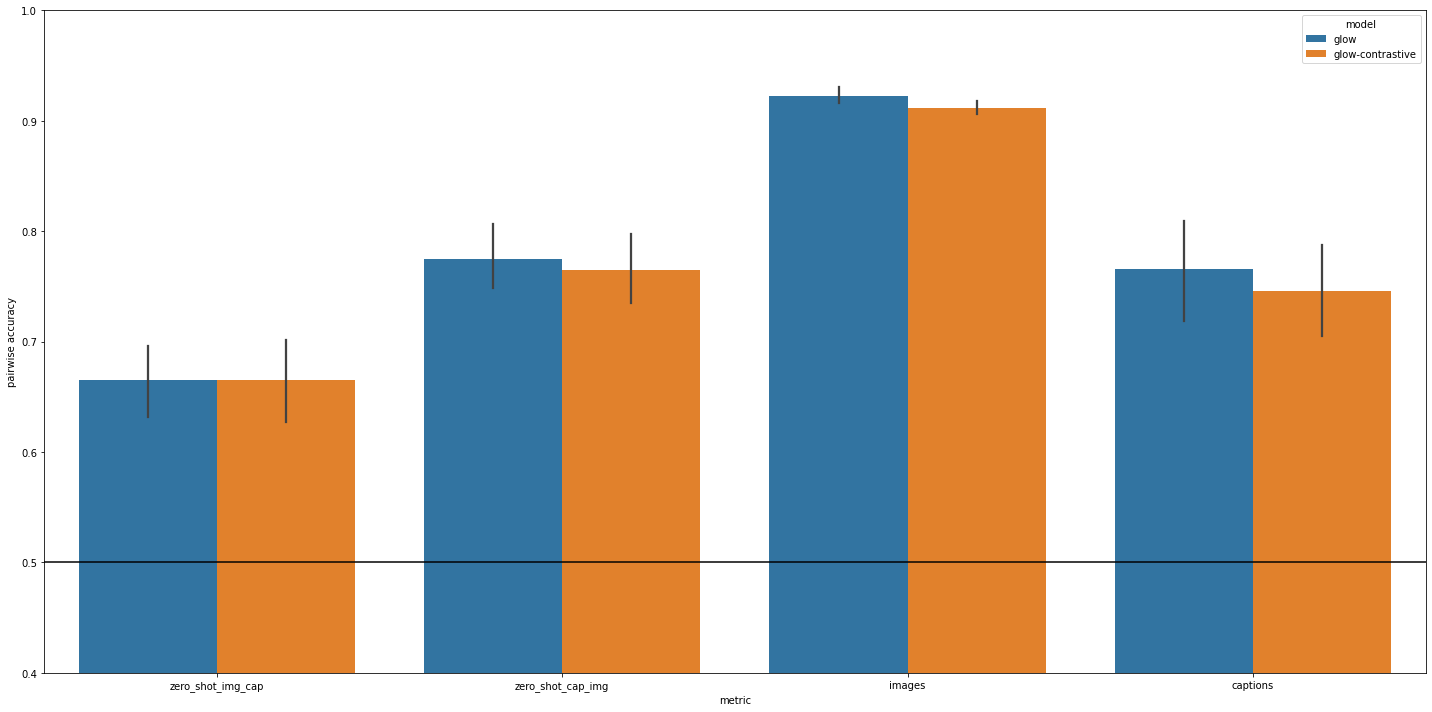

In [6]:
plt.figure(figsize=(20, 10))
sns.barplot(data=results_table, x="metric", y="value", hue="model")
plt.ylim((0.4, 1))
plt.axhline(y=0.5, color="black")
plt.ylabel("pairwise accuracy")
plt.tight_layout()
plt.savefig("glow_zero_shot_cross_modal_decoding.png", dpi=300, facecolor='white', transparent=False)